# Imports

In [109]:
%pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [110]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, label_col="label"):
    """
    Preprocess the DataFrame:
    - Separate labels from features.
    - Replace inf/-inf with NaN, fill NaNs with 0.
    - Remove columns with zero variance.
    - Scale features using StandardScaler.
    """
    y = df[label_col].values
    X = df.drop(columns=[label_col]).select_dtypes(include=[np.number])  # Keep numeric features

    # Handle NaN and Inf values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Remove zero-variance features
    X = X.loc[:, X.var(axis=0) != 0]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled



In [111]:
# Load features and labels
features = np.load('../feature_extraction_smooth/image_features.npy')  # shape: (num_images, 500)
labels = np.load('../feature_extraction_smooth/image_labels.npy')        # shape: (num_images,)


# features =np.load('../ImageDataGenerator/preprocessed_images.npy')  # shape: (num_images, 500)
# labels =np.load('../ImageDataGenerator/preprocessed_labels.npy')  # shape: (num_images, 500)





# # Normalize the features with StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# features= preprocess_data(features)

# Assuming labels are integers from 0 to (num_categories-1).
num_classes = len(np.unique(labels))

# Convert labels to one-hot encoding
labels_categorical = to_categorical(labels, num_classes=num_classes)

In [112]:
# Split into training and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, stratify=labels, random_state=42)


In [113]:
from sklearn.mixture import GaussianMixture

# Determine the number of components based on unique labels
n_components = num_classes

# Apply GMM
gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=100, verbose=2)
gmm.fit(X_train)

# Print convergence status
print(f"Number of Components: {n_components}")
print(f"GMM Converged: {gmm.converged_}")

# Assign GMM cluster labels
gmm_labels_train = gmm.predict(X_train)
gmm_labels_test = gmm.predict(X_test)

# gmm_labels_test = y_test
# gmm_labels_train = y_train


Initialization 0
Initialization converged. time lapse 2.56157s	 lower bound 2415.09530.
Number of Components: 15
GMM Converged: True


Training KNN: 100%|██████████| 30/30 [00:00<00:00, 39.09k-value/s]


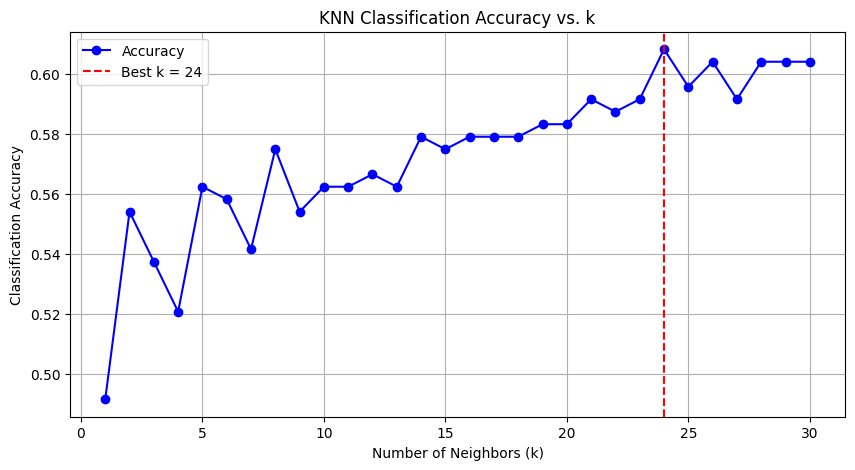

Best k: 24, Best Accuracy: 0.61


In [114]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Test k values from 1 to 30
k_values = range(1, 31)
accuracies = []

# Train KNN for different k values
with tqdm(total=len(k_values), desc="Training KNN", unit="k-value") as pbar:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, gmm_labels_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(gmm_labels_test, y_pred)
        accuracies.append(acc)
        pbar.update(1)

# Find the best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

# Plot accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Classification Accuracy")
plt.title("KNN Classification Accuracy vs. k")
plt.legend()
plt.grid()
plt.show()

print(f"Best k: {best_k}, Best Accuracy: {best_accuracy:.2f}")


In [115]:
# k_values = range(1, 31)
# accuracies_real = []

# with tqdm(total=len(k_values), desc="Evaluating KNN (Real Labels)", unit="k-value") as pbar:
#     for k in k_values:
#         knn = KNeighborsClassifier(n_neighbors=k)
#         knn.fit(X_train, gmm_labels_train)
#         gmm_pred_test = knn.predict(X_test)

#         # Remap GMM labels to original labels
#         label_mapping = {}
#         for gmm_label in np.unique(gmm_labels_train):
#             indices = np.where(gmm_labels_train == gmm_label)[0]
#             original_labels_subset = labels[indices]
#             most_common_label = np.bincount(original_labels_subset).argmax()
#             label_mapping[gmm_label] = most_common_label

#         # Convert GMM predictions to original labels
#         predicted_labels = np.array([label_mapping[label] for label in list(gmm_pred_test)])
#         # predicted_labels = np.array([label_mapping[label] if label in label_mapping else -1 for label in gmm_pred_test])
        
#         actual_labels_eval = np.argmax(y_test, axis=1)
#         acc = accuracy_score(actual_labels_eval, predicted_labels)
#         accuracies_real.append(acc)

#         pbar.update(1)

# # Find best k based on actual label accuracy
# best_k_real = k_values[np.argmax(accuracies_real)]
# best_accuracy_real = max(accuracies_real)

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, accuracies_real, marker='o', linestyle='-', color='g', label="Real Label Accuracy")
# plt.axvline(best_k_real, color='r', linestyle='--', label=f'Best k = {best_k_real}')
# plt.xlabel("Number of Neighbors (k)")
# plt.ylabel("Accuracy (Original Labels)")
# plt.title("KNN Accuracy vs. k (Compared with Original Labels)")
# plt.legend()
# plt.grid()
# plt.show()

# print(f"Best k (Real Labels): {best_k_real}, Best Accuracy (Real Labels): {best_accuracy_real:.2f}")


In [116]:
# Train KNN with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, gmm_labels_train)

# Predict on train and test data
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Compute accuracy
accuracy_train = accuracy_score(gmm_labels_train, y_pred_train)
accuracy_test = accuracy_score(gmm_labels_test, y_pred_test)

print(f"Train Accuracy: {accuracy_train:.2f}")
print(f"Test Accuracy: {accuracy_test:.2f}")


Train Accuracy: 0.84
Test Accuracy: 0.61


In [117]:
#print classification report
from sklearn.metrics import classification_report
print("Classification Report (Train):")
print(classification_report(gmm_labels_train, y_pred_train, target_names=[str(i) for i in range(num_classes)]))
print("Classification Report (Test):")
print(classification_report(gmm_labels_test, y_pred_test, target_names=[str(i) for i in range(num_classes)]))


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.69      0.99      0.82       131
           1       0.88      0.86      0.87        69
           2       0.91      0.54      0.67        56
           3       0.85      0.92      0.88        72
           4       0.92      0.98      0.95       112
           5       1.00      0.64      0.78        22
           6       0.87      0.89      0.88        85
           7       0.89      0.73      0.80        66
           8       0.86      0.95      0.90        57
           9       0.93      0.52      0.67        27
          10       0.88      0.56      0.69        39
          11       0.81      0.85      0.83        67
          12       1.00      0.67      0.80        39
          13       0.77      0.89      0.82        87
          14       1.00      0.65      0.78        31

    accuracy                           0.84       960
   macro avg       0.88      0.77      0.81      

c:\Users\jyoti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyoti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jyoti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [118]:
# Convert one-hot encoded labels back to their original class indices
actual_labels = np.argmax(y_test, axis=1)

# Map GMM predicted labels back to original labels
predicted_labels = np.array([label_mapping[label] for label in np.argmax(y_test, axis=1)])

# Print actual vs predicted labels
for actual, predicted in zip(actual_labels, predicted_labels):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Show the name of the class
# Class-wise accuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()



Actual: 2, Predicted: 3
Actual: 11, Predicted: 4
Actual: 1, Predicted: 1
Actual: 1, Predicted: 1
Actual: 3, Predicted: 3
Actual: 6, Predicted: 0
Actual: 2, Predicted: 3
Actual: 12, Predicted: 1
Actual: 9, Predicted: 10
Actual: 3, Predicted: 3
Actual: 11, Predicted: 4
Actual: 2, Predicted: 3
Actual: 6, Predicted: 0
Actual: 7, Predicted: 7
Actual: 2, Predicted: 3
Actual: 9, Predicted: 10
Actual: 10, Predicted: 0
Actual: 3, Predicted: 3
Actual: 3, Predicted: 3
Actual: 4, Predicted: 1
Actual: 11, Predicted: 4
Actual: 0, Predicted: 6
Actual: 0, Predicted: 6
Actual: 5, Predicted: 3
Actual: 8, Predicted: 8
Actual: 1, Predicted: 1
Actual: 13, Predicted: 2
Actual: 7, Predicted: 7
Actual: 1, Predicted: 1
Actual: 2, Predicted: 3
Actual: 3, Predicted: 3
Actual: 14, Predicted: 11
Actual: 5, Predicted: 3
Actual: 11, Predicted: 4
Actual: 11, Predicted: 4
Actual: 14, Predicted: 11
Actual: 10, Predicted: 0
Actual: 3, Predicted: 3
Actual: 13, Predicted: 2
Actual: 3, Predicted: 3
Actual: 10, Predicted: 0

In [119]:
from joblib import dump, load

# Save the trained model to a file
dump(knn, 'knn_model_smooth.joblib')

# Load the trained model from the file
loaded_knn = load('knn_model_smooth.joblib')

# Predict using the loaded model
y_pred_loaded_train = loaded_knn.predict(X_train)
accuracy_score_loaded_train = accuracy_score(gmm_labels_train, y_pred_loaded_train)
print(f"Loaded Model Train Accuracy: {accuracy_score_loaded_train:.2f}")


Loaded Model Train Accuracy: 0.84


In [120]:
#y_pred is the predicted labels from the KNN model in gmm_labels_test
#i need to convert the predicted labels back to the original labels
# Create a mapping from GMM labels to original labels
label_mapping = {}
for gmm_label in np.unique(gmm_labels_train):
    # Get the indices of the samples that belong to this GMM label
    indices = np.where(gmm_labels_train == gmm_label)[0]
    
    # Get the original labels for these samples
    original_labels = labels[indices]
    
    # Find the most common original label for this GMM label
    most_common_label = np.bincount(original_labels).argmax()
    
    # Map the GMM label to the most common original label
    label_mapping[gmm_label] = most_common_label

# Convert GMM labels to original labels using the mapping
predicted_labels = np.array([label_mapping[label] for label in gmm_labels_test])
print("Predicted labels:")
print(predicted_labels)

Predicted labels:
[ 6  1  6  6  6  6  6  6  6  3  6  6  6  2  6  8  6  6  6  6  7  2  2  1
  6  6  1  2 11  6  3  6  1  6  8  6  0  3  0  6  0  1  6  6  6  1  6  6
  8  6  6  6  8  6  6  6  6  8  7  6  7  6  6  6  1  1  6  6  6  6  2  1
  3  6  6  6  6  1  6  6  6  6  6  6  6  6  6  1  2  8  1  1  1  6  6  6
  6  1  3  1  6  6  6  0  7  6  6  6  2  2  6  6  6  6  6  6  6  1  1  0
  0  1  6  3  6  6  6  1  2  6  6  0  6  0 10  6  6  0  6  0  6  6  6  2
  6  6  6  6  0  6  1  1  6 11  6  6  4  6  6  6  6  6  6  6  1  1  6  6
  6  1  6  6  3  2  6  6  6  6  6  2  0  6  6  7  6  6  6  6  6  6  0  6
  1  6  6  8  2  0  3  6  6  1  3  6  6  0  6  3  6  6  6  6  6  6  1  2
  1  6  6  1  1  6  1  6  1  2  1  2  6  1  6  1  0  6  4  2  1  6  1  6]
